In [12]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import os
from sklearn import metrics

In [13]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Importing the feature engineered validation and train sets, in order to avoid all the preprocessing

In [14]:
train_final = pd.read_csv('train_after_engineering.csv', index_col=0) 
validation_final = pd.read_csv('validation_after_engineering.csv', index_col=0) 
test = pd.read_csv('test.csv')

## XGBoost

#### XGBoost training with best parameters we have already found in XGBoost_linear.ipynb file

In [15]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                             max_depth=3, min_child_weight=1, missing=None, n_estimators=120,
                             n_jobs=3, nthread=None, objective='binary:logistic',
                             random_state=500, reg_alpha=1, reg_lambda=0.8, scale_pos_weight=1,
                             seed=None, silent=False, subsample=1, verbose=10)

In [16]:
train_final['adexchange'] = train_final['adexchange'].fillna(4)
X_xgb = train_final.drop(columns = ['bidprice', 'payprice', 'click']).astype(float)
y_xgb = train_final['click']  # Labels

validation_final['adexchange'] = validation_final['adexchange'].fillna(4)
X_v_xgb = validation_final.drop(columns = ['bidprice', 'payprice', 'click']).astype(float)
y_v_xgb = validation_final['click']


In [17]:
model_xgb.fit(X_xgb, y_xgb)
pred_xgb = model_xgb.predict(X_v_xgb)

print (metrics.classification_report(y_v_xgb, pred_xgb))
print (metrics.confusion_matrix(y_v_xgb, pred_xgb))
print ('PD XGBoost AU ROC (Hold out Set): ', metrics.roc_auc_score(y_v_xgb,  model_xgb.predict_proba(X_v_xgb)[:,1] ))

[19:52:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:52:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:52:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:52:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[19:52:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[19:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[19:52:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[19:52:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    303723
           1       0.07      0.41      0.12       202

   micro avg       1.00      1.00      1.00    303925
   macro avg       0.53      0.70      0.56    303925
weighted avg       1.00      1.00      1.00    303925

[[302634   1089]
 [   120     82]]
PD XGBoost AU ROC (Hold out Set):  0.8853875712637196


In [18]:
predicted_XGB_CTR = model_xgb.predict_proba(X_v_xgb)[:,1]
predicted_XGB_CTR

array([0.0239841 , 0.01590747, 0.03889485, ..., 0.06182635, 0.03165899,
       0.04819798], dtype=float32)

#### Final recalibrated pCTRs

In [19]:
w = 0.0073 # class 0, downsampling rate
predicted_XGB_CTR = predicted_XGB_CTR/(predicted_XGB_CTR+((1-predicted_XGB_CTR)/w)) 
predicted_XGB_CTR

array([0.00017935, 0.00011799, 0.00029534, ..., 0.00048084, 0.00023861,
       0.00036953], dtype=float32)

## Square Bidding Strategy

Without Budget limit:  0.0 Num Clicks:  0 With Budget limit:  0.0 Num Clicks:  0 CTR:  0.0 won impressions:  80 basebid:  0.0
Without Budget limit:  241.50400000000002 Num Clicks:  88 With Budget limit:  241.50400000000002 Num Clicks:  88 CTR:  0.01637513956084853 won impressions:  5374 basebid:  0.002006688963210702
Without Budget limit:  440.79200000000003 Num Clicks:  99 With Budget limit:  440.79200000000003 Num Clicks:  99 CTR:  0.011244888686960473 won impressions:  8804 basebid:  0.004013377926421404
Without Budget limit:  573.743 Num Clicks:  108 With Budget limit:  573.743 Num Clicks:  108 CTR:  0.009711356892365795 won impressions:  11121 basebid:  0.006020066889632107
Without Budget limit:  685.5070000000001 Num Clicks:  112 With Budget limit:  685.5070000000001 Num Clicks:  112 CTR:  0.008528784648187633 won impressions:  13132 basebid:  0.008026755852842809
Without Budget limit:  790.5740000000001 Num Clicks:  115 With Budget limit:  790.5740000000001 Num Clicks:  115 CTR:

Without Budget limit:  3429.870000000001 Num Clicks:  148 With Budget limit:  3429.870000000001 Num Clicks:  148 CTR:  0.0021551410306816362 won impressions:  68673 basebid:  0.0903010033444816
Without Budget limit:  3489.967000000001 Num Clicks:  149 With Budget limit:  3489.967000000001 Num Clicks:  149 CTR:  0.002135282315849814 won impressions:  69780 basebid:  0.0923076923076923
Without Budget limit:  3554.196 Num Clicks:  149 With Budget limit:  3554.196 Num Clicks:  149 CTR:  0.002102589430607493 won impressions:  70865 basebid:  0.094314381270903
Without Budget limit:  3609.803 Num Clicks:  151 With Budget limit:  3609.803 Num Clicks:  151 CTR:  0.00210057731098282 won impressions:  71885 basebid:  0.09632107023411371
Without Budget limit:  3668.6420000000007 Num Clicks:  151 With Budget limit:  3668.6420000000007 Num Clicks:  151 CTR:  0.002068323151521793 won impressions:  73006 basebid:  0.09832775919732441
Without Budget limit:  3731.3130000000006 Num Clicks:  152 With Budg

Without Budget limit:  5842.254 Num Clicks:  163 With Budget limit:  5842.254 Num Clicks:  163 CTR:  0.0015024980181774607 won impressions:  108486 basebid:  0.1785953177257525
Without Budget limit:  5894.040000000001 Num Clicks:  163 With Budget limit:  5894.040000000001 Num Clicks:  163 CTR:  0.0014916495081217112 won impressions:  109275 basebid:  0.1806020066889632
Without Budget limit:  5949.646000000001 Num Clicks:  163 With Budget limit:  5949.646000000001 Num Clicks:  163 CTR:  0.0014808354455679413 won impressions:  110073 basebid:  0.18260869565217389
Without Budget limit:  5999.034 Num Clicks:  165 With Budget limit:  5999.034 Num Clicks:  165 CTR:  0.00148911591639291 won impressions:  110804 basebid:  0.1846153846153846
Without Budget limit:  6047.577 Num Clicks:  165 With Budget limit:  6047.577 Num Clicks:  165 CTR:  0.0014791971097384959 won impressions:  111547 basebid:  0.1866220735785953
Without Budget limit:  6098.42 Num Clicks:  165 With Budget limit:  6098.42 Num 

Without Budget limit:  7925.927000000001 Num Clicks:  175 With Budget limit:  6249.952 Num Clicks:  137 CTR:  0.0012607207273530386 won impressions:  108668 basebid:  0.2688963210702341
Without Budget limit:  7971.465000000001 Num Clicks:  175 With Budget limit:  6249.926 Num Clicks:  137 CTR:  0.0012627077246375475 won impressions:  108497 basebid:  0.2709030100334448
Without Budget limit:  8010.93 Num Clicks:  175 With Budget limit:  6249.875 Num Clicks:  137 CTR:  0.0012642925037605782 won impressions:  108361 basebid:  0.2729096989966555
Without Budget limit:  8047.7519999999995 Num Clicks:  175 With Budget limit:  6249.982 Num Clicks:  136 CTR:  0.001256107360234966 won impressions:  108271 basebid:  0.27491638795986617
Without Budget limit:  8089.533 Num Clicks:  176 With Budget limit:  6249.866000000001 Num Clicks:  137 CTR:  0.0012672512672512672 won impressions:  108108 basebid:  0.2769230769230769
Without Budget limit:  8127.671000000001 Num Clicks:  176 With Budget limit:  6

Without Budget limit:  9547.358000000002 Num Clicks:  180 With Budget limit:  6249.960000000001 Num Clicks:  117 CTR:  0.0011261694836946059 won impressions:  103892 basebid:  0.357190635451505
Without Budget limit:  9581.172000000002 Num Clicks:  180 With Budget limit:  6249.9400000000005 Num Clicks:  116 CTR:  0.0011173291979310145 won impressions:  103819 basebid:  0.3591973244147157
Without Budget limit:  9613.645000000002 Num Clicks:  180 With Budget limit:  6249.991 Num Clicks:  116 CTR:  0.0011178567986894093 won impressions:  103770 basebid:  0.3612040133779264
Without Budget limit:  9645.024 Num Clicks:  180 With Budget limit:  6249.979000000001 Num Clicks:  116 CTR:  0.0011187084703590477 won impressions:  103691 basebid:  0.36321070234113706
Without Budget limit:  9676.913999999999 Num Clicks:  180 With Budget limit:  6249.9890000000005 Num Clicks:  115 CTR:  0.0011100814703270396 won impressions:  103596 basebid:  0.36521739130434777
Without Budget limit:  9708.381 Num Clic

Without Budget limit:  10943.155999999999 Num Clicks:  185 With Budget limit:  6249.851 Num Clicks:  103 CTR:  0.0010219876170820764 won impressions:  100784 basebid:  0.4474916387959866
Without Budget limit:  10974.574 Num Clicks:  185 With Budget limit:  6249.911000000002 Num Clicks:  103 CTR:  0.0010230636285981048 won impressions:  100678 basebid:  0.4494983277591973
Without Budget limit:  11002.447000000002 Num Clicks:  185 With Budget limit:  6249.957 Num Clicks:  103 CTR:  0.0010235211113650592 won impressions:  100633 basebid:  0.451505016722408
Without Budget limit:  11031.293000000001 Num Clicks:  185 With Budget limit:  6249.987000000001 Num Clicks:  103 CTR:  0.0010244271164863144 won impressions:  100544 basebid:  0.45351170568561866
Without Budget limit:  11058.345000000001 Num Clicks:  185 With Budget limit:  6249.786 Num Clicks:  102 CTR:  0.0010149859693116008 won impressions:  100494 basebid:  0.4555183946488294
Without Budget limit:  11095.836000000003 Num Clicks:  1

Without Budget limit:  12156.422999999999 Num Clicks:  190 With Budget limit:  6249.974000000001 Num Clicks:  95 CTR:  0.0009683798495443518 won impressions:  98102 basebid:  0.5377926421404682
Without Budget limit:  12180.885000000002 Num Clicks:  190 With Budget limit:  6249.950000000001 Num Clicks:  95 CTR:  0.00096891318537859 won impressions:  98048 basebid:  0.5397993311036788
Without Budget limit:  12203.893 Num Clicks:  190 With Budget limit:  6249.957 Num Clicks:  95 CTR:  0.0009694866823145219 won impressions:  97990 basebid:  0.5418060200668896
Without Budget limit:  12229.581000000004 Num Clicks:  190 With Budget limit:  6249.947000000002 Num Clicks:  95 CTR:  0.000970110388350506 won impressions:  97927 basebid:  0.5438127090301003
Without Budget limit:  12251.907000000003 Num Clicks:  190 With Budget limit:  6249.959000000002 Num Clicks:  95 CTR:  0.0009703382905703546 won impressions:  97904 basebid:  0.545819397993311
Without Budget limit:  12279.008000000002 Num Clicks

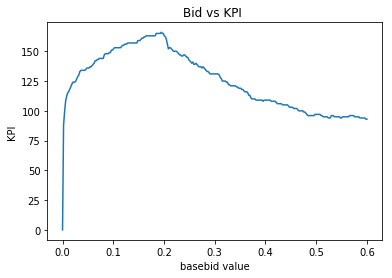

Optimal basebid is:  0.1946488294314381 , Optimal num clicks:  166 , impressions: 114437
budget spent: 6249.983 , avgCPM: 54.61505457151097 , avgCPC: 37.6505
CTR:  0.14505797949963736 %


In [20]:
budget = 6250
optimal_basebid = 0
optimal_num_clicks = 0
num_won_auctions = 0
base_bids_array = []
num_clicks_array = []

avg_ctr = 7.375e-04 


# Line search to find optimal base bid
for bid in np.linspace(0.0, 0.6, 300):
    validation_final['bid'] = bid * (predicted_XGB_CTR/avg_ctr)**2
    
    Won_Auctions = validation_final[ (validation_final['bid'] >= validation_final['slotprice']) & (validation_final['bid'] >=validation_final['payprice']) ]
    exceeding_indexes = np.flatnonzero( (Won_Auctions['payprice'].cumsum().values) > budget  )
    
    # Budget exceeded
    if len(exceeding_indexes) > 0:
        ExceedBudget_Index = exceeding_indexes[0]
        num_clicks = Won_Auctions[:ExceedBudget_Index]['click'].sum()
        budget_spent = Won_Auctions[:ExceedBudget_Index]['payprice'].sum()
        num_won_auctions = len(Won_Auctions[:ExceedBudget_Index])
    
    # No budget exceeded
    else:
        num_clicks = Won_Auctions[:]['click'].sum()
        budget_spent = Won_Auctions[:]['payprice'].sum()
        num_won_auctions = len(Won_Auctions[:])
    
    # Max clicks achieved --> optimal basebid
    if num_clicks > optimal_num_clicks:
        optimal_basebid = bid
        optimal_num_clicks = num_clicks
        optimal_impressions = num_won_auctions
        opt_budget = budget_spent
    
    print ('Without Budget limit: ', Won_Auctions['payprice'].sum(), 'Num Clicks: ',Won_Auctions['click'].sum() , 
           'With Budget limit: ', budget_spent, "Num Clicks: ", num_clicks , 
           "CTR: ", num_clicks/num_won_auctions, 'won impressions: ', num_won_auctions , "basebid: ", bid)
    
    base_bids_array.append(bid)
    num_clicks_array.append(num_clicks)


# bids vs number of clicks, plot
plt.plot(base_bids_array, num_clicks_array)
plt.xlabel("basebid value")
plt.ylabel("KPI")
plt.title("Bid vs KPI ")
plt.show()


avgCPM = (opt_budget/optimal_impressions)*1000
avgCPC = (opt_budget/optimal_num_clicks)

optimal_bids = optimal_basebid * ((predicted_XGB_CTR/avg_ctr)**2)

print ("Optimal basebid is: ", optimal_basebid, ", Optimal num clicks: ", optimal_num_clicks, ', impressions:', optimal_impressions)
print('budget spent:', opt_budget , ', avgCPM:', avgCPM, ', avgCPC:', avgCPC)
print('CTR: ' , (optimal_num_clicks/optimal_impressions)*100, '%')

## Optimal bids for the validation set


In [11]:
optimal_bids = optimal_bids * 1000
aaa = pd.DataFrame(optimal_bids)
aaa.to_csv('optimalbids_validation_square.csv')

## Optimal bids for the test set

Similar steps of feature engineering must take place

In [21]:
def preprocess_df(df):

    
    #---real price-----    
    if 'bidprice' and 'payprice' in df.columns:
        df['bidprice'] = df['bidprice'].apply( lambda x: x/1000.0 )
        df['payprice'] = df['payprice'].apply( lambda x: x/1000.0 )
       
        
    #---slot area-----  
    df['slot_area']=df['slotwidth'] * df['slotheight'] 
    
    #----real price---   
    df['slotprice'] = df['slotprice'].apply( lambda x: x/1000.0 )
    
    
    # ----browser/OS splitting--    
    df['OS'] = df['useragent'].apply( lambda x: x.split('_')[0] )
    df['browser'] = df['useragent'].apply( lambda x: x.split('_')[1] ) 
    df['OS'] = df['OS'].astype('category')
    df['browser'] = df['browser'].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    
    df['advertiser'] = df['advertiser'].astype('category')
    df['adexchange'] = df['adexchange'].astype('category')
    df['city'] = df['city'].astype('category')
    df['region'] = df['region'].astype('category')
    df['weekday'] = df['weekday'].astype('category')

    return df   
        

def tag(df):
    df['usertag'] = df['usertag'].apply(lambda x: str(x).split(','))
    
    AllTags = np.array(df['usertag'])
    Tags = [tag for usertags in AllTags for tag in usertags]
    Tags = list(set(Tags))
    
    for t in Tags:
        df['usertag_' + t] = df['usertag'].apply(lambda x: int(t in x))
    
    return df


In [22]:
test_final = preprocess_df(test)
test_final = tag(test)

In [23]:
# Dropping the same columns as before, except for bidid
test_final = test_final.drop(columns = ['usertag', 'useragent', 'slotheight', 'slotwidth','urlid','IP', 'domain', 'url','slotid', 'keypage','userid', 'creative', 'slotvisibility','slotformat'])

In [24]:
test_final.shape

(303375, 80)

In [25]:
test_final_final = pd.DataFrame(0, index=range(0,len(test_final)), columns=list( train_final.columns ))

for col in train_final:
    if col in test_final:
        test_final_final[col] = np.array( test_final[col] )

In [26]:
test_final_final.shape

(303375, 80)

In [27]:
test_final_final['adexchange'] = test_final_final['adexchange'].fillna(4)
X_test = test_final_final.astype(float)
X_test = X_test.drop(columns = ['bidprice', 'payprice', 'click'])

test_pred = model_xgb.predict(X_test)

#### pCTR for the test set

In [28]:
test_pCTR = model_xgb.predict_proba(X_test)[:,1]
test_pCTR

array([0.15464635, 0.25799447, 0.01843025, ..., 0.01211043, 0.14158835,
       0.01245131], dtype=float32)

#### Recalibration of the pCTR

In [29]:
test_pCTR_final = test_pCTR/(test_pCTR+((1-test_pCTR)/w)) 
test_pCTR_final

array([1.3336581e-03, 2.5317755e-03, 1.3704824e-04, ..., 8.9481917e-05,
       1.2026303e-03, 9.2032140e-05], dtype=float32)

In [30]:
final_bids = optimal_basebid * (test_pCTR_final/avg_ctr)**2   

In [33]:
bbb = test[['bidid']]
bbb['bidprice'] = final_bids*1000
bbb.to_csv('Group_14_square.csv', index=False)

C:\Users\apogn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
